In [1]:
import matplotlib.pyplot as plt
from Functions.connection.connection import *
from Functions.Models.Logistic_regression import *
from Functions.Models.Random_forest import *
from Functions.Models.xgboost import *
from Functions.Models.evaluation import *
from Functions.Pipelines.pipeline_NLP import *


2023-05-29 17:12:45.662752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 17:12:46.319881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
alertP1=connection("credentials.csv")
#alertP1=connection("/Users/MarouanKamoun/Desktop/HGO pbl/credentials.csv")


Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
707


/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [3]:
data = pre_process(alertP1)

/home/marouankamoun/Desktop/PBL-HGO/Functions/AlertP1/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/home/marouankamoun/Desktop/PBL-HGO/Functions/AlertP1/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
/home/marouankamoun/Desktop/PBL-HGO/Functions/AlertP1/data_cleaning.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

# XGBOOST

In [5]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text_caveman','clean_text','chi_squared']#'chi_squared'
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns
y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [6]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Precision-Recall trade-off,0.45,0.8,0.98,0.79,0.88
1,Cohen's Kappa,0.57,0.8,0.90,0.83,0.90


In [7]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Precision-Recall trade-off,0.45,0.69,0.98,0.69,0.68
1,Cohen's Kappa,0.57,0.72,0.91,0.73,0.72


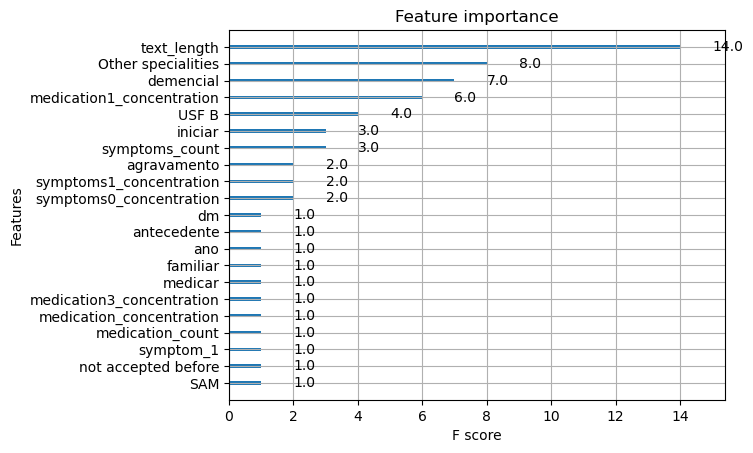

In [9]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

## combiantions

In [4]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text_caveman','clean_text','LDA_text','tf_idf text']#'chi_squared'
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns
features

Index(['text_length', 'outside area', 'SAM', 'SON', 'unknown',
       'Other specialities', '2', '3+', 'HOSP', 'UCSP',
       ...
       'dim_91', 'dim_92', 'dim_93', 'dim_94', 'dim_95', 'dim_96', 'dim_97',
       'dim_98', 'dim_99', 'dim_100'],
      dtype='object', length=173)

In [18]:
word2vec_features


Index(['dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5', 'dim_6', 'dim_7', 'dim_8',
       'dim_9', 'dim_10', 'dim_11', 'dim_12', 'dim_13', 'dim_14', 'dim_15',
       'dim_16', 'dim_17', 'dim_18', 'dim_19', 'dim_20', 'dim_21', 'dim_22',
       'dim_23', 'dim_24', 'dim_25', 'dim_26', 'dim_27', 'dim_28', 'dim_29',
       'dim_30', 'dim_31', 'dim_32', 'dim_33', 'dim_34', 'dim_35', 'dim_36',
       'dim_37', 'dim_38', 'dim_39', 'dim_40', 'dim_41', 'dim_42', 'dim_43',
       'dim_44', 'dim_45', 'dim_46', 'dim_47', 'dim_48', 'dim_49', 'dim_50',
       'dim_51', 'dim_52', 'dim_53', 'dim_54', 'dim_55', 'dim_56', 'dim_57',
       'dim_58', 'dim_59', 'dim_60', 'dim_61', 'dim_62', 'dim_63', 'dim_64',
       'dim_65', 'dim_66', 'dim_67', 'dim_68', 'dim_69', 'dim_70', 'dim_71',
       'dim_72', 'dim_73', 'dim_74', 'dim_75', 'dim_76', 'dim_77', 'dim_78',
       'dim_79', 'dim_80', 'dim_81', 'dim_82', 'dim_83', 'dim_84', 'dim_85',
       'dim_86', 'dim_87', 'dim_88', 'dim_89', 'dim_90', 'dim_91', 'dim_92'

In [14]:
non_Nlp=features[0:14]
wordsearch_features=features[14:36]
LDA_features=features[36:39]
#chi_squared_features=features[39:110]
tfidf_features=features[39:59]
bert_features=features[59:73]#bert_features=features[110:124]#
word2vec_features=features[73:]#word2vec_features=features[124:]#


from itertools import compress, product
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
  #This fonctions will be used to have every combinations of features for the model
def combinations(items):
      return ( list(set(compress(items,mask))) for mask in product(*[[0,1]]*len(items)) )


def lgbm(all_columns,y):
      new_x=X[all_columns]
      y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(new_x,y)
      thresholds = np.linspace(0, 1, 100)
       # Cohen's Kappa
      kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
      kappa_threshold = thresholds[np.argmax(kappas)]
      kappa_y_pred_train_binary = (y_pred_train >= kappa_threshold).astype(int)
      kappa_y_pred_test_binary = (y_pred_test >= kappa_threshold).astype(int)
      kappa_recall_train = recall_score(y_train, kappa_y_pred_train_binary)
      kappa_recall_test = recall_score(y_test, kappa_y_pred_test_binary)
      kappa_precision_train = precision_score(y_train, kappa_y_pred_train_binary)
      kappa_precision_test = precision_score(y_test, kappa_y_pred_test_binary)
      return(round(kappa_recall_train, 2),round(kappa_precision_train, 2),round(kappa_recall_test, 2),round(kappa_precision_test, 2))

d = pd.DataFrame(columns=["Features_used","recall train","precision train","recall test","precision test"])

all_columns = [non_Nlp,wordsearch_features,LDA_features,tfidf_features,bert_features,word2vec_features]
#all_columns = [non_Nlp,wordsearch_features,LDA_features,chi_squared_features,bert_features,word2vec_features]
  #Iterate over every combinations of features and train the model,
  #get the MAE and append it with the features used in the dataframe
combi_col = list(combinations(np.arange(start=0, stop=len(all_columns))))[1:] #starting from index 1 to drop empty list
group_names = ['non_Nlp', 'wordsearch', 'LDA','tfidf ','bert', 'Word2vec']
#group_names = ['non_Nlp', 'wordsearch', 'LDA', 'chi_squared', 'bert', 'Word2vec']

for columns in combi_col:
    selected_columns_group = [group_names[i] for i in columns]
    selected_columns = [all_columns[i] for i in columns]
    flattened_columns = [col for sublist in selected_columns for col in sublist]  # Flatten the list
    recall_train,precision_train,recall_test,precision_test = lgbm(flattened_columns, y)
    d = d.append({"Features_used": ",".join(selected_columns_group), "recall train": recall_train,"precision train": precision_train,"recall test": recall_test,"precision test": precision_test}, ignore_index=True)

d['Rank'] = d[['recall test', 'precision test']].apply(tuple,axis=1).rank(ascending=0).astype(int)
d = d.sort_values(['recall test', 'precision test'], ascending=[False, False])
d = d[["Rank", "Features_used", "recall train","precision train","recall test","precision test"]]

/tmp/ipykernel_3912187/3810816458.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append({"Features_used": ",".join(selected_columns_group), "recall train": recall_train,"precision train": precision_train,"recall test": recall_test,"precision test": precision_test}, ignore_index=True)
/tmp/ipykernel_3912187/3810816458.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append({"Features_used": ",".join(selected_columns_group), "recall train": recall_train,"precision train": precision_train,"recall test": recall_test,"precision test": precision_test}, ignore_index=True)
/tmp/ipykernel_3912187/3810816458.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append({"Features_used": ",".join(selected_col

In [19]:
# Save the dataframe to a CSV file
d.to_csv('results_tfidf.csv', index=False)

In [15]:
d.head(20)

,Rank,Features_used,recall train,precision train,recall test,precision test
4,1,"tfidf ,Word2vec",0.95,0.83,0.93,0.69
24,2,"wordsearch,LDA,Word2vec",0.94,0.85,0.92,0.70
2,3,"bert,Word2vec",0.91,0.86,0.91,0.72
44,3,"non_Nlp,LDA,tfidf ,Word2vec",0.94,0.83,0.91,0.72
28,5,"wordsearch,LDA,tfidf ,Word2vec",0.93,0.85,0.91,0.70
16,6,"wordsearch,Word2vec",0.92,0.85,0.90,0.70
20,6,"wordsearch,tfidf ,Word2vec",0.93,0.86,0.90,0.70
13,8,"LDA,tfidf ,bert",0.94,0.85,0.89,0.69
5,9,"tfidf ,bert",0.90,0.86,0.88,0.71
6,9,"tfidf ,bert,Word2vec",0.91,0.86,0.88,0.71
